# Clustering Analysis

In this notebook we perform a kmeans clustering analysis on the output of probtrackx aggregated over 36 subjects. 

In [29]:
import pandas as pd
import numpy as np 
import os
import joblib
import shutil
import nibabel as nib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
%matplotlib inline
warnings.filterwarnings(action='once')

Here we will load a previously generated sparse matrix. The 'kmeans_dti.py' file has code that generates sparse matricies.

In [3]:
mat = joblib.load('../data/aggregate_matrix.pkl')

Now we transpose the matrix and calculate the cross-correlation. Since we want to cluster MPFC based on similarity of connectivity, we want to cluster the correlation matrix.

In [4]:
mat = mat.T
CC = 1 + np.corrcoef(mat)
CC = np.nan_to_num(CC)

In [5]:
kmeans = [KMeans(n_clusters=i).fit(CC) for i in range(2,7)] # clustering solutions for k = 2,3,4,5,6
clusters = [k.predict(CC) for k in kmeans]
silhouette_avg = [silhouette_score(CC, cluster) for cluster in clusters]
for i in range(2,7):
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg[i-2])

For n_clusters = 2 The average silhouette_score is : 0.30147451923703894
For n_clusters = 3 The average silhouette_score is : 0.2925412161971984
For n_clusters = 4 The average silhouette_score is : 0.2962106370805253
For n_clusters = 5 The average silhouette_score is : 0.29578943376622213
For n_clusters = 6 The average silhouette_score is : 0.2753257015337752


In [7]:
# get coords data
os.chdir('../data/')
file = open('seed_coords.txt')
data = file.readlines()
x,y,z = [],[],[]
voxel_num = [] 
for line in data:
    split = line.split('  ')
    x.append(int(split[0]))
    y.append(int(split[1]))
    z.append(int(split[2].replace('/n', '')))
    voxel_num.append(int(split[4].replace('/n', '')))

In [8]:
seed_df = pd.DataFrame()
seed_df['x'] = pd.Series(x)
seed_df['y'] = pd.Series(y)
seed_df['z'] = pd.Series(z)
seed_df['voxel_num'] = pd.Series(voxel_num)

# add cluster data
seed_df['k=2'] = pd.Series(clusters[0]) + 1
seed_df['k=3'] = pd.Series(clusters[1]) + 1
seed_df['k=4'] = pd.Series(clusters[2]) + 1
seed_df['k=5'] = pd.Series(clusters[3]) + 1
seed_df['k=6'] = pd.Series(clusters[4]) + 1

In [9]:
# create and load empty brains
dims = (91,109,91)
brains = [np.zeros(dims) for i in range(5)]
for i in range(seed_df.shape[0]):
    brains[0][seed_df['x'][i]][seed_df['y'][i]][seed_df['z'][i]] = seed_df['k=2'][i]
    brains[1][seed_df['x'][i]][seed_df['y'][i]][seed_df['z'][i]] = seed_df['k=3'][i]
    brains[2][seed_df['x'][i]][seed_df['y'][i]][seed_df['z'][i]] = seed_df['k=4'][i]
    brains[3][seed_df['x'][i]][seed_df['y'][i]][seed_df['z'][i]] = seed_df['k=5'][i]
    brains[4][seed_df['x'][i]][seed_df['y'][i]][seed_df['z'][i]] = seed_df['k=6'][i]

In [12]:
MNI = nib.load('/usr/local/fsl/data/standard/MNI152_T1_2mm.nii.gz')
header = MNI.header
header.set_data_dtype(brains[0].dtype)  

for i in range(5):
    header['cal_max'] = brains[i].max()
    header['cal_min'] = brains[i].min()
    img = nib.nifti1.Nifti1Image(brains[i], None, header=header)
    filename = 'MPFC_k%s.nii.gz' % str(i+2) 
    img.to_filename(filename)

Now let's see what the clusters look like.

In [27]:
from nilearn import plotting as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
colors = sns.color_palette('Set1', 6)
files = ['MPFC_k2.nii.gz','MPFC_k3.nii.gz','MPFC_k4.nii.gz','MPFC_k5.nii.gz','MPFC_k6.nii.gz']

/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda2/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


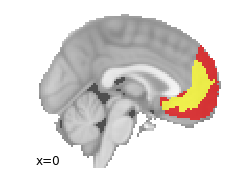

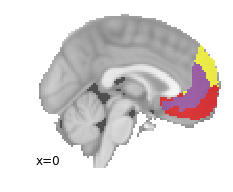

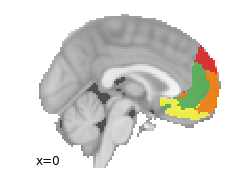

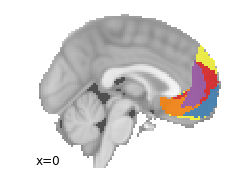

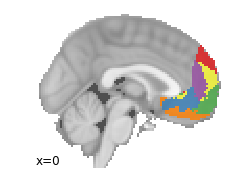

In [31]:
for file in files:
    plt.plot_roi(file, cut_coords=[0], display_mode='x', 
             cmap = ListedColormap(colors), alpha=0.8)

There are some interesting things here. It looks like there are some distinctions between dmPFC and vmPFC as well as rACC and vACC. Overall, these clusters seem to make some sense and are loosely consistent with distinctions in the literature. It'll be interesting to see what clusters are the most robust when I add a lot more data.